# What Is This Notebook?

this notebook is just one that I'm creating to reimplement my CNN for the CIFAR-10 dataset but using the functional API rather than Sequential.
I will create another one using the functional API again but also using transfer learning.

I know that the functional API isn't necessary for this implementation as I only have one output but I just want to get comfortable with the API.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import cifar10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()  # fallback to multi-GPU or single CPU/GPU

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=0)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
with strategy.scope():
    inputs = keras.Input(shape=(32, 32, 3))

    # Conv layer 1
    x = layers.Conv2D(filters=512, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Dropout(.2924515218223497)(x)

    # Conv layer 2
    x = layers.Conv2D(filters=1024, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Dropout(.20420635555557912)(x)

    # Conv layer 3
    x = layers.Conv2D(filters=1024, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Dropout(.4938435933532547)(x)

    # Conv layer 4
    x = layers.Conv2D(filters=512, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Dropout(.477406309189756)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(342, activation='relu')(x)
    x = layers.Dropout(.49155865824030837)(x)
    output = layers.Dense(10, activation='softmax')(x)

    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=output, name='tpu_model')
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

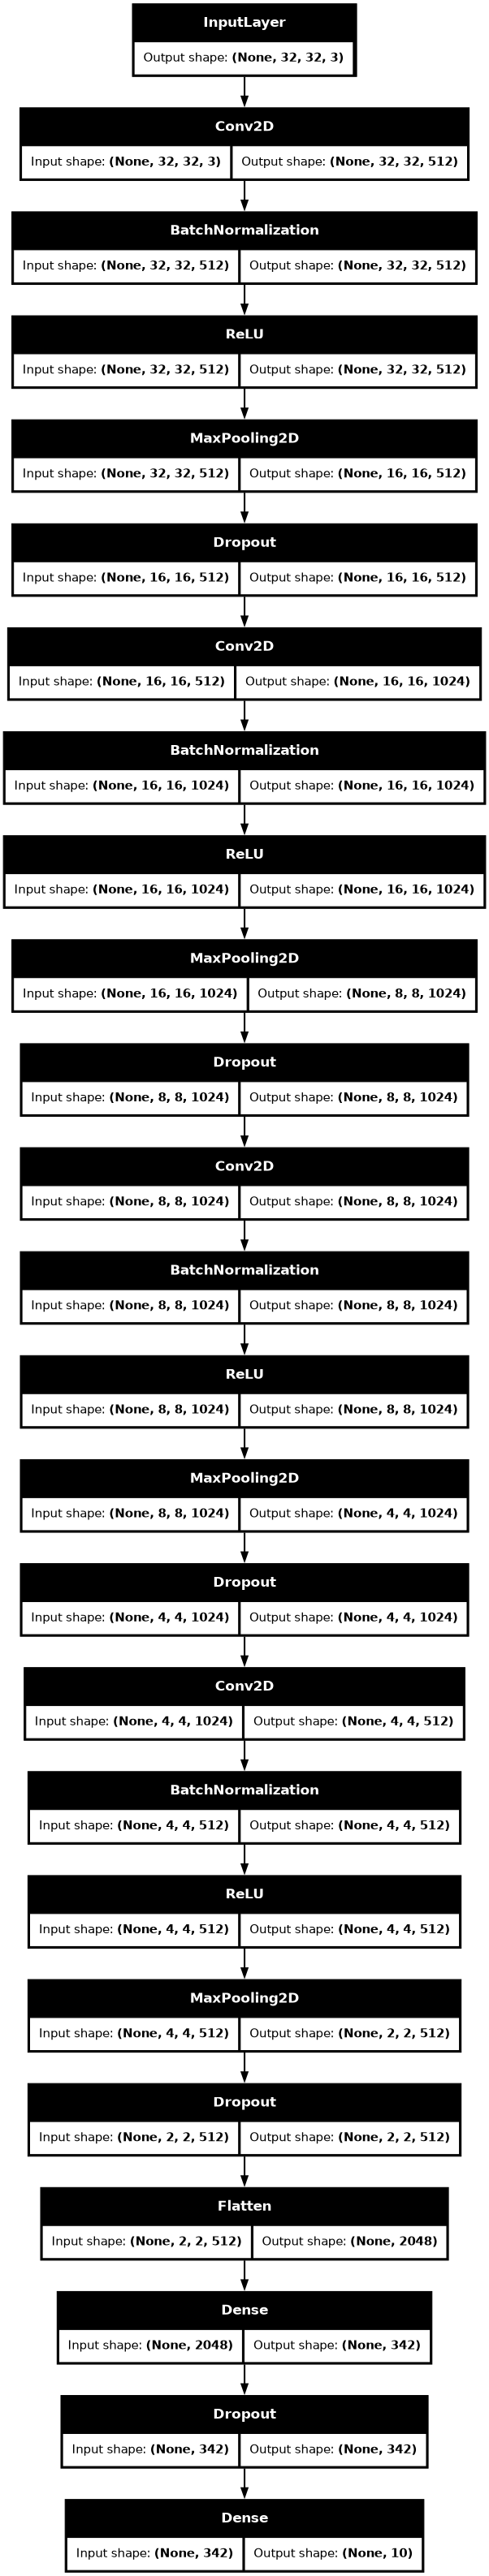

In [5]:
keras.utils.plot_model(model, 'my_model.png', show_shapes=True, dpi=75)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=5,
    min_delta=.001,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],
    epochs=100
)


Epoch 1/100


2024-09-22 21:44:27.498142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/tpu_model_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1118/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 2.1344 - sparse_categorical_accuracy: 0.2656

<Axes: >

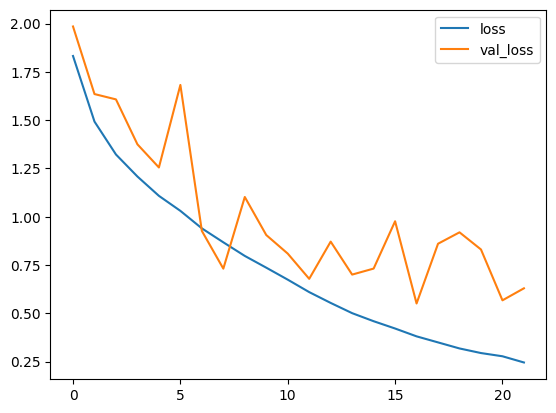

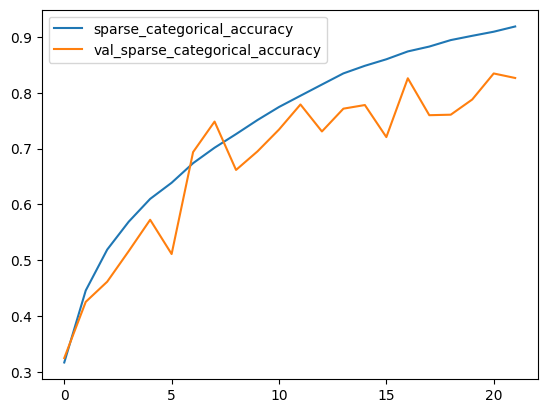

In [13]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5836 - sparse_categorical_accuracy: 0.8250
0.5833765268325806
0.8203999996185303
